In [1]:
library(Seurat)
library(ggplot2)   
# library(ggpubr)    

### Cell cycle analysis ###
# Generate barplots or boxplots of meta groups proportions specified
# meta_groups: vector or meta group names:
# 1) first meta_group is the group on which proportions are calculated
# 2) second meta_group split first meta_group on x axes  
#   3) third meta_group will group barplots separately
# if splits include only one value runs barplot instead
cellComp = function (
    seurat_obj = NULL, 
    metaGroups = NULL, # vector of at least 3 metaGroups e.g. c('orig.ident','celltypes','celltypes'),
    plot_as = 'box', # box or bar 
    pal = NULL,
    prop = TRUE,
    ptable_factor = 1, # specify which column of the data.frame or seurat object metadata should be used to compute proportions
    facet_ncol = 20,
    facet_scales = 'free',
    subset_prop = NULL, # subset prop table by any group in any column
    removeNA = TRUE,
    returnDF = FALSE
)
{
  if (is.data.frame (seurat_obj))
  {
    meta_groups_df = seurat_obj[,metaGroups]    
  } else {
    meta_groups_df = seurat_obj@meta.data[,metaGroups]
  }
  # Refactor to remove 0 groups
  #meta_groups_df =  as.data.frame(lapply(unclass(meta_groups_df),as.character),stringsAsFactors=T)
  if(is.null(pal)) pal = rainbow (length(unique(meta_groups_df[,2])))
  #if(is.null(pal) & plot_as == 'box') pal = rainbow (length(unique(meta_groups_df[,3])))
  if (prop)
  {
    ccomp_df = as.data.frame (prop.table (table (meta_groups_df),ptable_factor))
    ccomp_df = na.omit (ccomp_df) # this is to remove NaN somehow produced from the line above 
  } else {
    ccomp_df = as.data.frame (table (meta_groups_df))   
  }
  
  if(removeNA) ccomp_df = ccomp_df[ccomp_df$Freq != 0, ] # remove 0s from proportions
  if (!is.null (subset_prop)) 
  {
    subset_col = unlist(sapply (seq(ncol(ccomp_df)), function(x) if(any(ccomp_df[,x] %in% subset_prop)) colnames(ccomp_df)[x]))
    ccomp_df = ccomp_df[ccomp_df[,subset_col] %in% subset_prop,]
  }
  #colnames (ccomp_df) = c(paste0('Var_',seq_along(metaGroups)), 'proportion')  
  if (plot_as == 'box')
  {
    p = ggplot (ccomp_df, aes_string (x= metaGroups[2], y= 'Freq')) +
      theme (axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
      scale_fill_manual (values= pal) + xlab (metaGroups[2]) + ylab (ifelse (prop, 'proportion','counts'))
    if (length(metaGroups > 2)) p = p + geom_boxplot(aes_string (fill= metaGroups[3]), outlier.size=.2, alpha = 0.7, lwd=.2) 
    else p = p + geom_boxplot(aes_string (fill= metaGroups[2]), outlier.size=.2, alpha = 0.7, lwd=.2)       
    if (length(metaGroups) > 3) p = p + facet_wrap (as.formula(paste("~", metaGroups[4])), scales=facet_scales, ncol=facet_ncol)
  }   
  if (plot_as == 'bar')
  {
    p = ggplot (ccomp_df, aes_string (x= metaGroups[1], y= 'Freq')) +
      geom_bar(position="stack", stat="identity", aes_string(fill= metaGroups[2])) +
      #geom_bar(position="dodge", stat="identity", aes_string(fill= metaGroups[2])) +
      theme (axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
      scale_fill_manual (values= pal) + xlab (metaGroups[2]) + ylab (ifelse (prop, 'proportion','counts'))
    if (length(metaGroups) == 3) p = p + facet_wrap (as.formula(paste("~", metaGroups[3])), scales=facet_scales, ncol=facet_ncol)
  }
  if (returnDF) return(ccomp_df) else 
    return (p)
}

### Variables needed ###
metaGroupName1 = "sample_ID"
metaGroupName2 = "Cluster"

# cc_transfer # assign cell identity of cycling cells using label transfer. Logical
srt = readRDS("../data/scRNAseq/tosti_pancreas/adult_pancreas_2020.rds")
if (!'cc' %in% colnames (srt@meta.data)) {
  cc.genes <- readLines('/ahg/regevdata/projects/ICA_Lung/Bruno/gene_sets/regev_lab_cell_cycle_genes.txt')
  s.genes <- cc.genes[1:43]
  g2m.genes <- cc.genes[44:97]
  
  message ("Calculate cell cycle score with Seurat CellCycleScoring function")
  srt = CellCycleScoring(object = srt, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
  srt$cc = srt$S.Score + srt$G2M.Score
} else {
  message ("Cell cycle scores found...generating plots")   
}  

srt$Phase2 = ifelse (srt$Phase == 'G1','non-cycling','cycling')
metaGroupNames = c(metaGroupName2, 'Phase2')
# ccc_box1 = cellComp (
#   seurat_obj = srt, 
#   metaGroups = metaGroupNames,
#   plot_as = 'box',
# #  pal = pal1,
#   prop = TRUE,
#   ptable_factor = c(1,3),
#   subset_prop = 'cycling',
#   facet_ncol = 6,
#   facet_scales = 'free'
#   ) + theme_classic()#+ NoLegend() + ggtitle (i)

ccc_bar1 = cellComp(
  seurat_obj = srt, 
  metaGroups = metaGroupNames,
  plot_as = 'bar',
  pal = c(cycling = 'blue', `non-cycling`= 'grey'),
  prop = TRUE,
  ptable_factor = c(1),
  #subset_prop = 'cycling',
  facet_ncol = 6,
  facet_scales = 'free'
) + theme_classic() + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size=25),
        axis.text.y = element_text(size=25))


The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Calculate cell cycle score with Seurat CellCycleScoring function

Warning message:
"`aes_string()` was deprecated in ggplot2 3.0.0.
i Please use tidy evaluation idioms with `aes()`.
i See also `vignette("ggplot2-in-packages")` for more information."


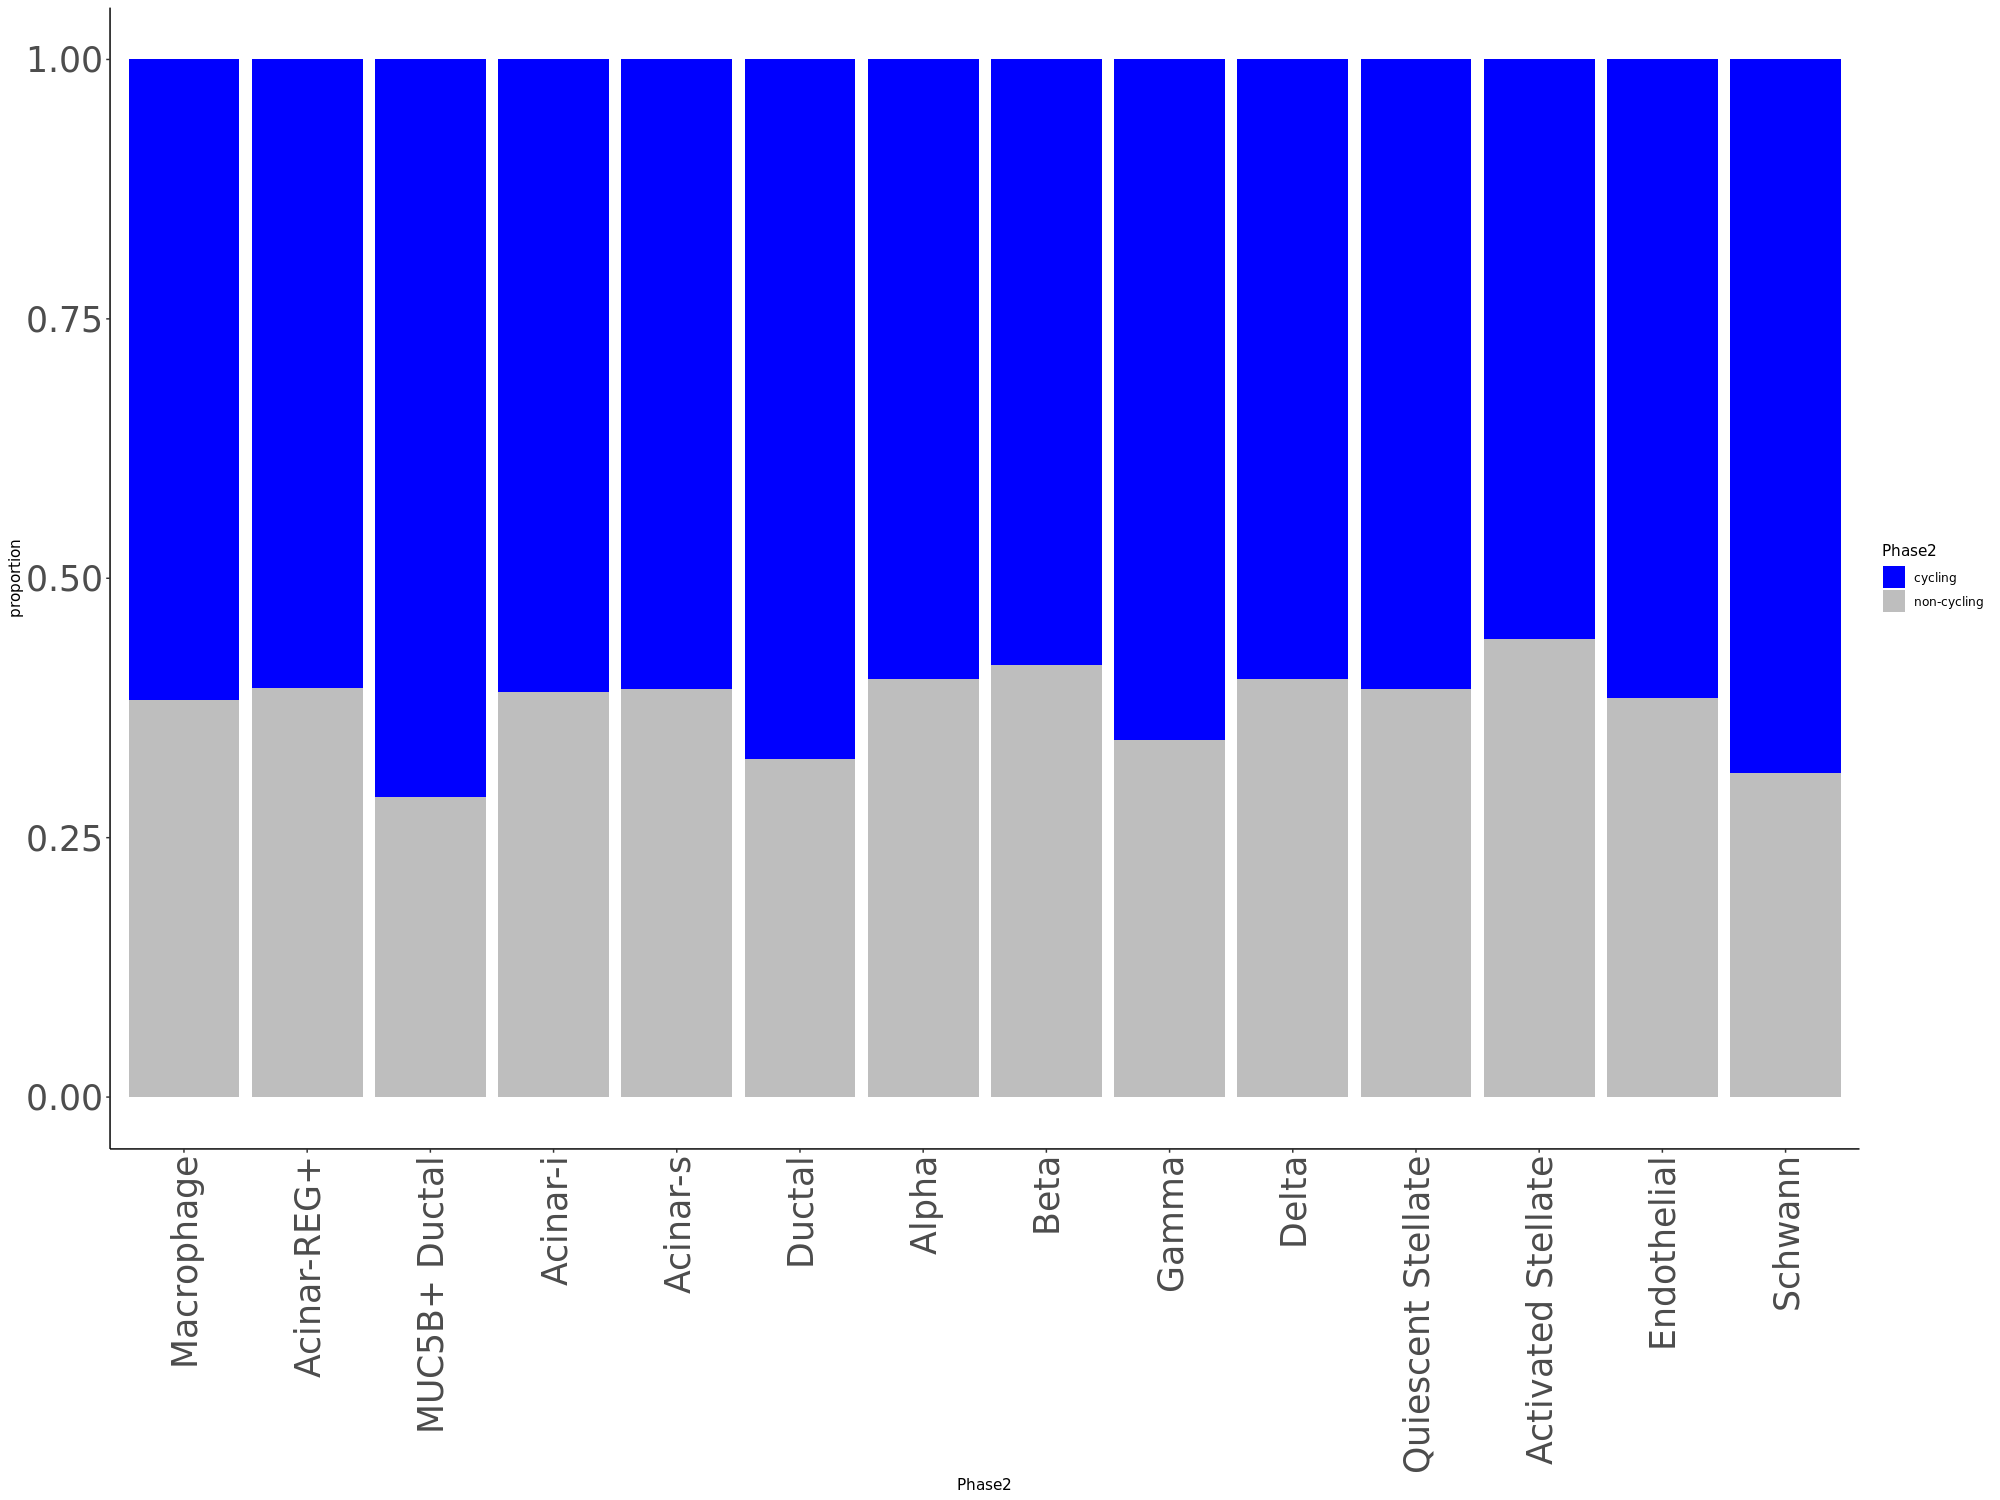

In [22]:
ccc_bar1

In [3]:
options(repr.plot.width = 20, repr.plot.height = 15, repr.plot.res = 100)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



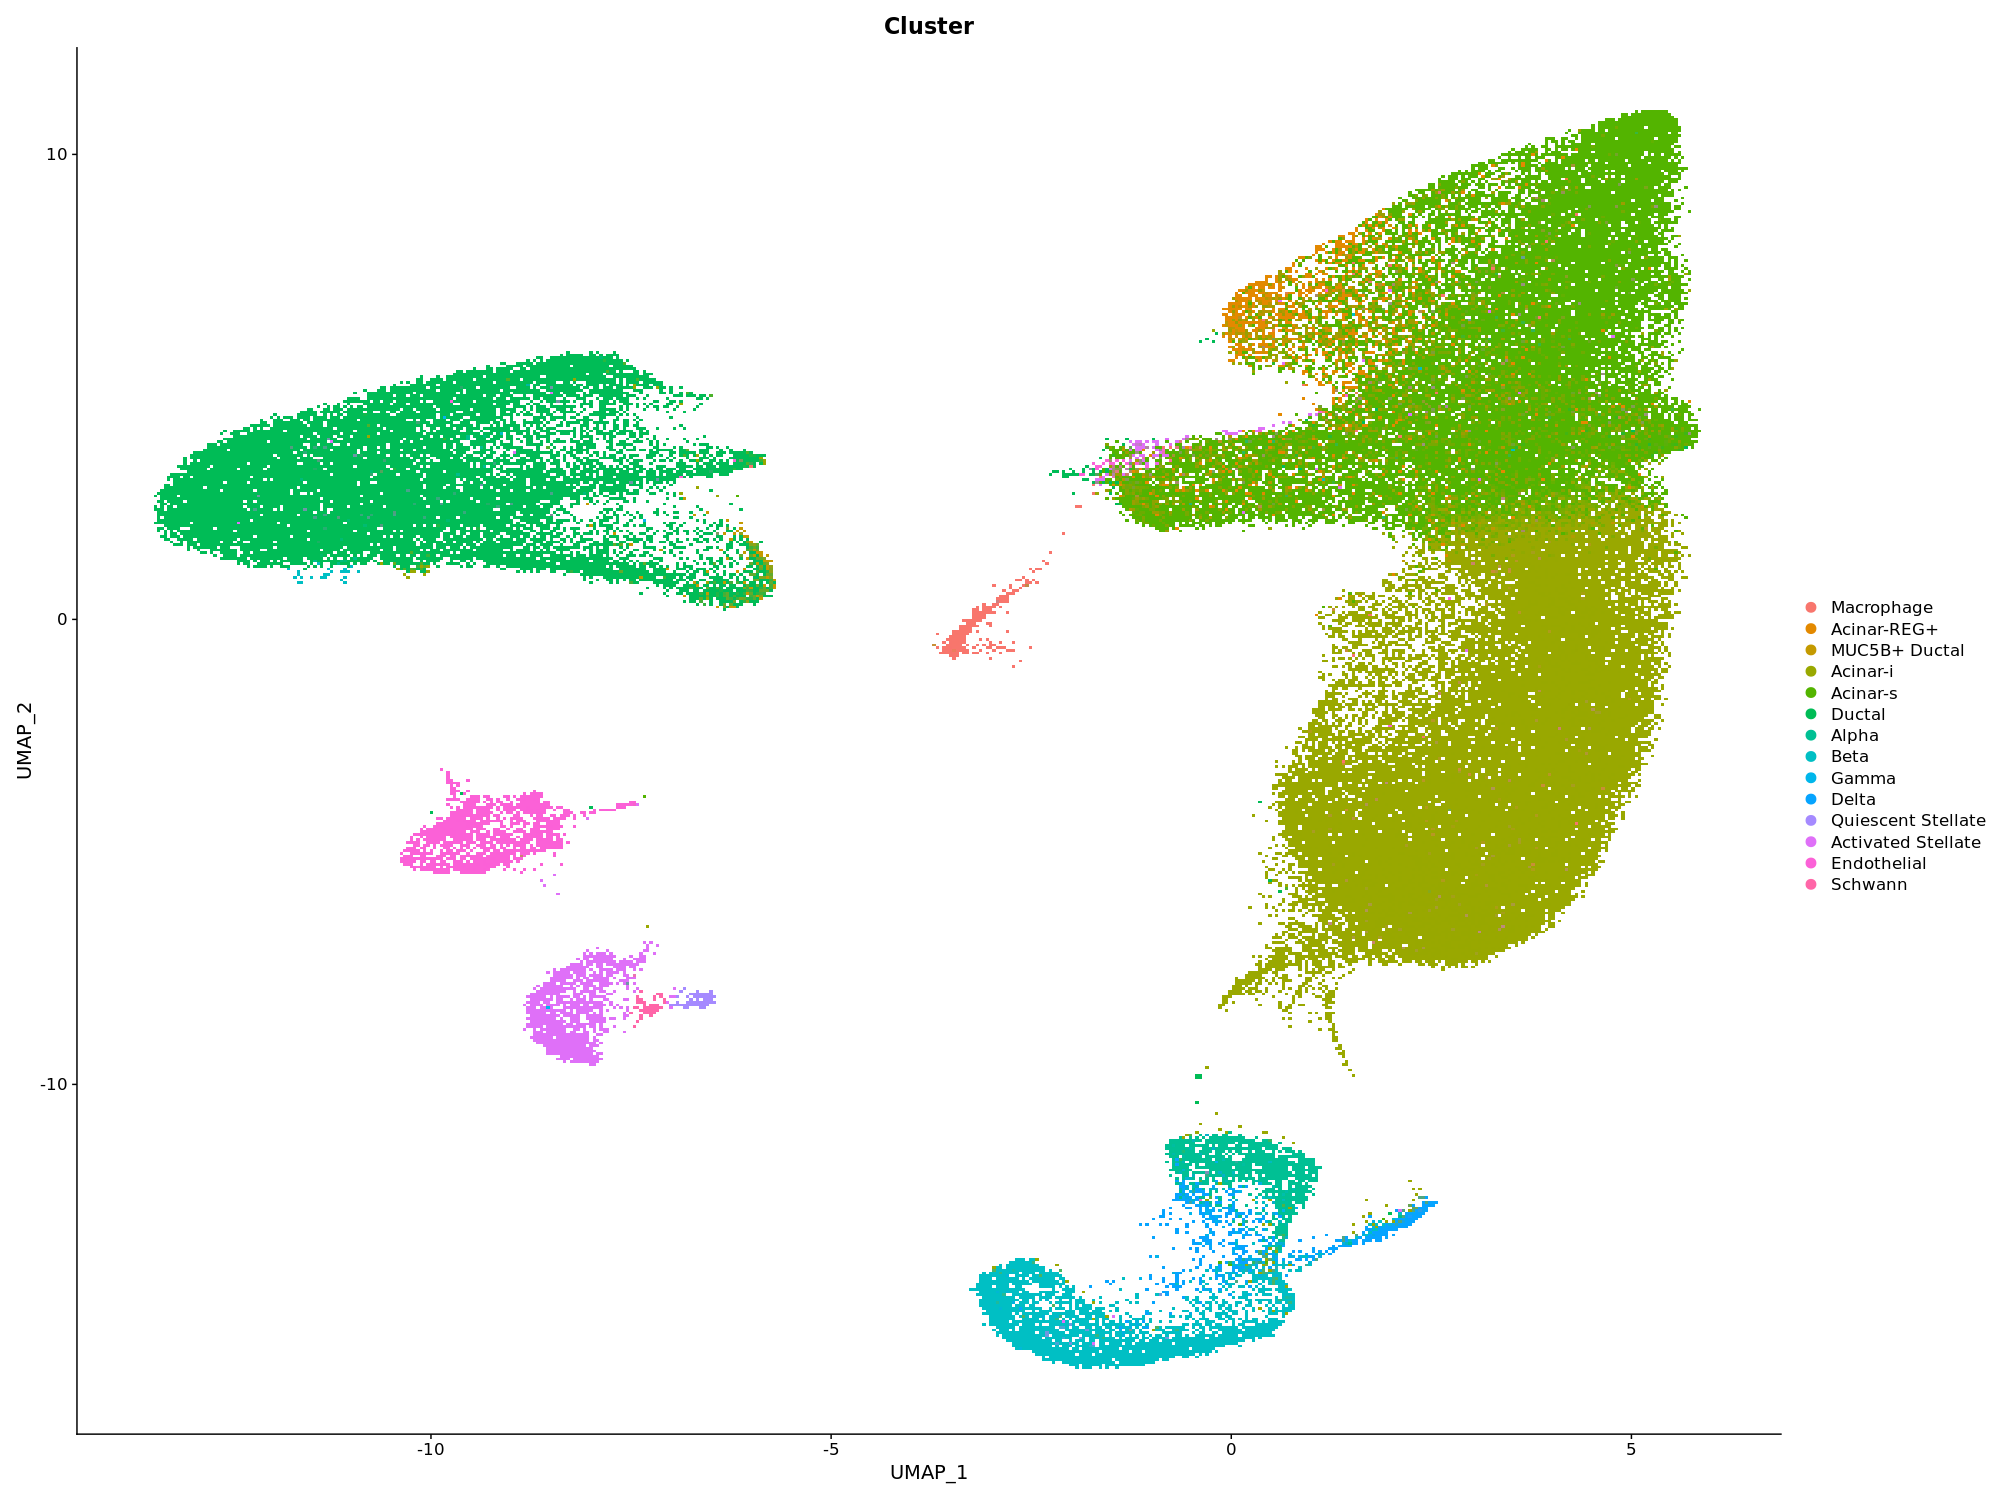

In [4]:
DimPlot(srt, group.by="Cluster")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



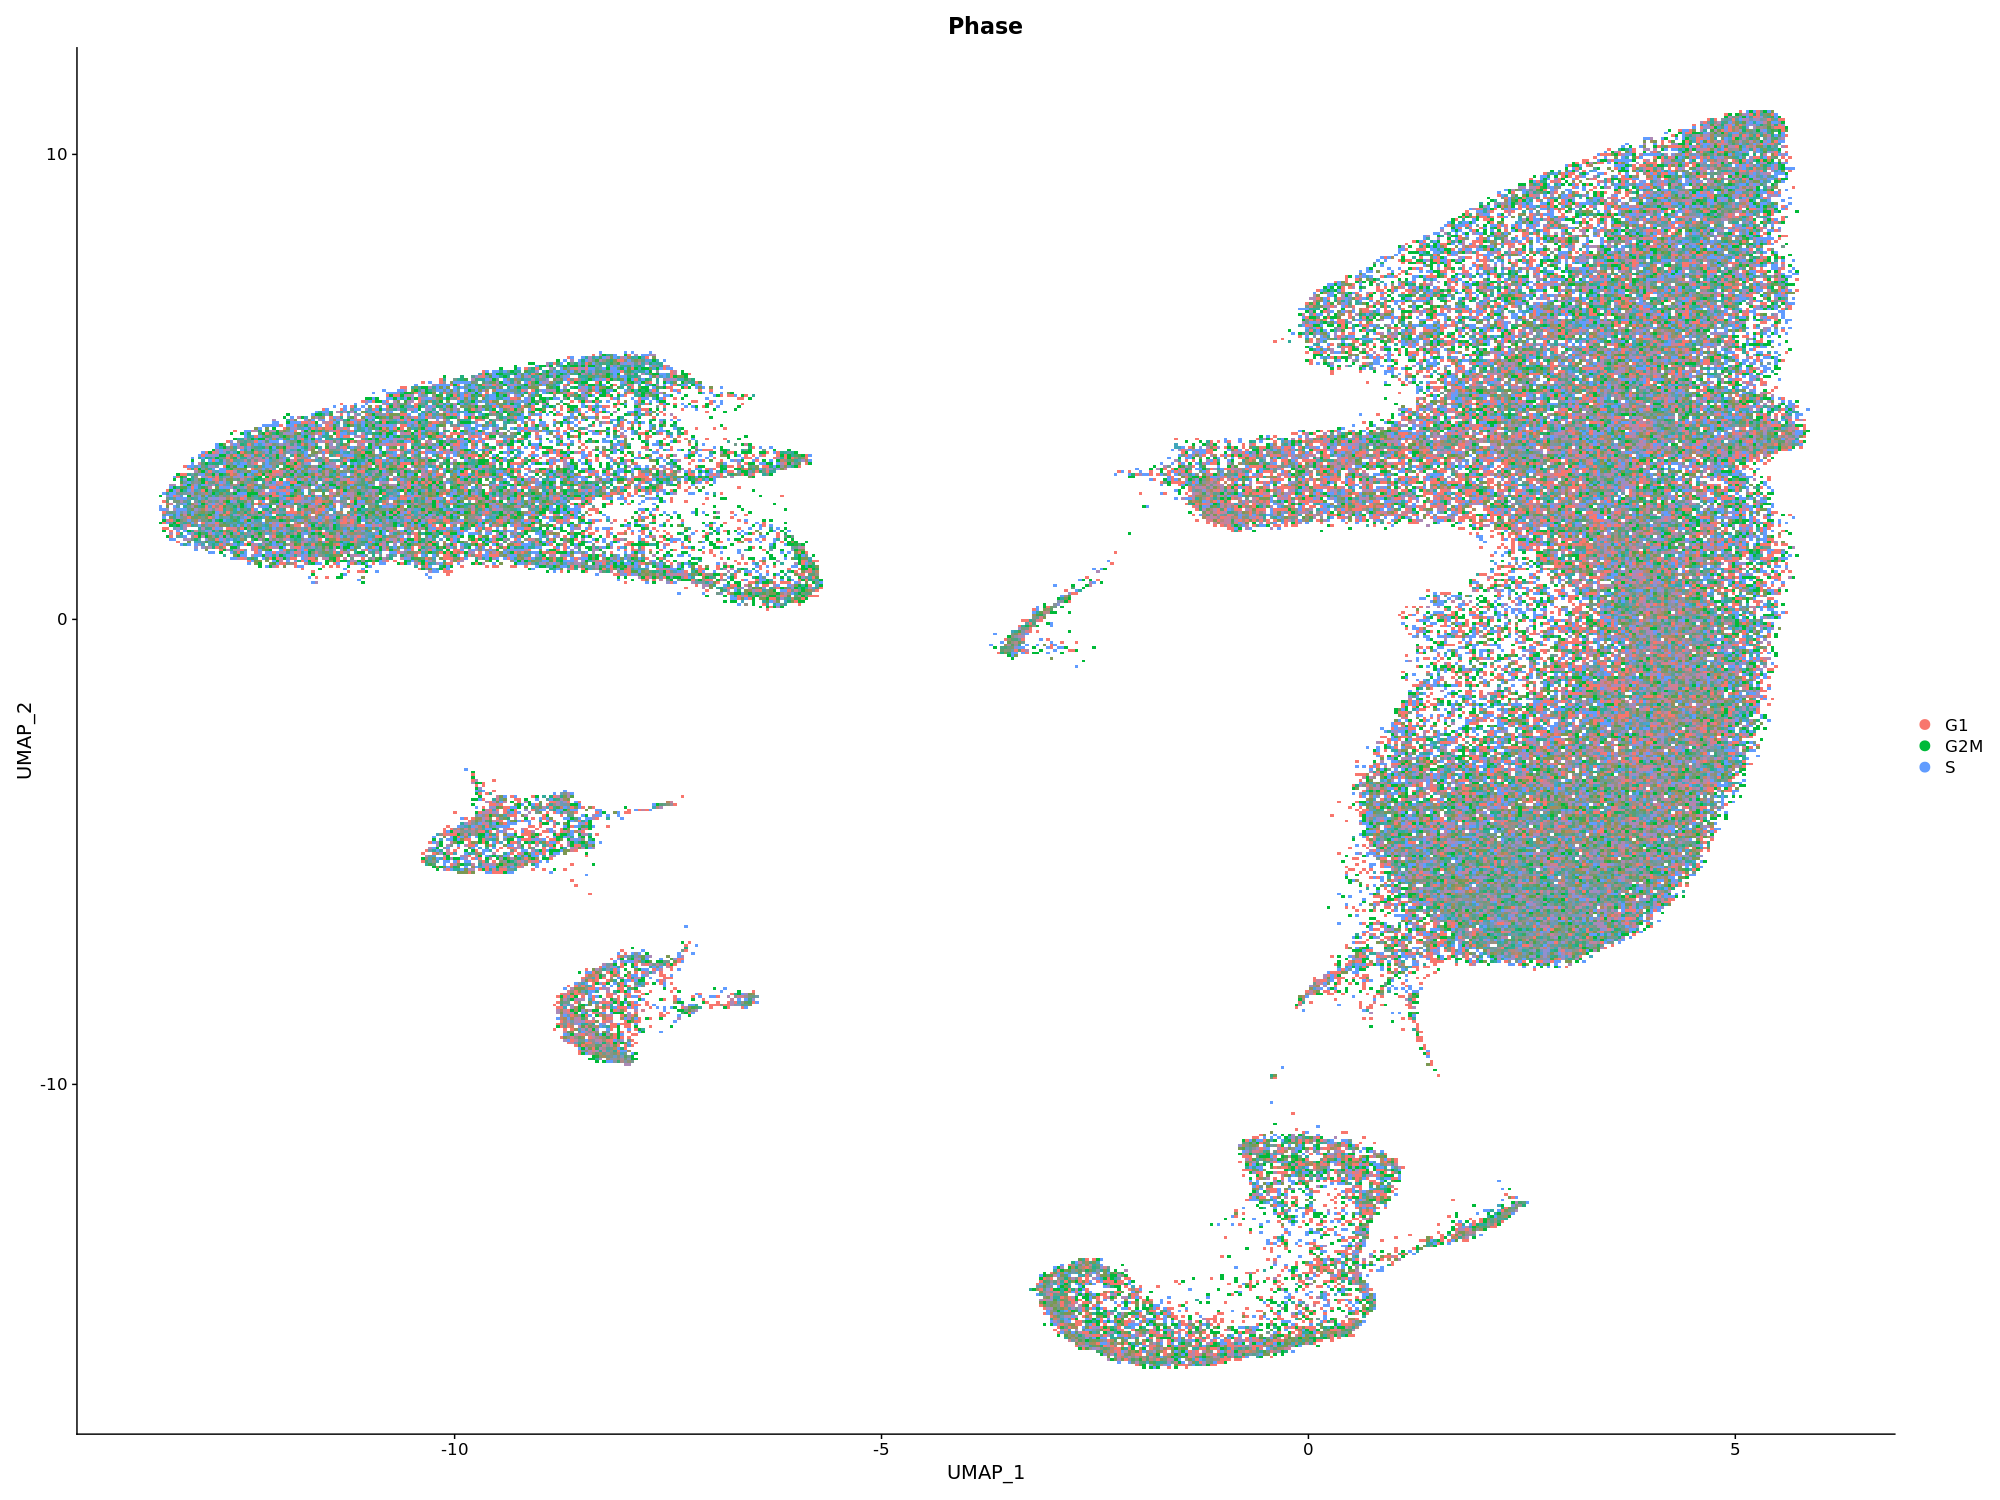

In [21]:
DimPlot(srt, group.by="Phase")

In [5]:
a = FindVariableFeatures(srt, nfeatures=20)

In [6]:
head(VariableFeatures(a), 20)

[1] "SST"      "REG3A"    "PPY"      "GCG"      "IAPP"     "APOD"    
 [7] "TTR"      "GHRL"     "SERPINE1" "RBP4"     "DARC"     "CCL21"   
[13] "CFD"      "TIMP3"    "MGP"      "DCN"      "APOE"     "REG3G"   
[19] "NTS"      "INS"

In [19]:
head(srt)

,nCount_RNA,nFeature_RNA,sample_ID,patient_ID,sex,age,pancreas_location,procurement_lab,Cluster,S.Score,G2M.Score,Phase,old.ident,cc,Phase2
,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<chr>
AAACCTGAGAAGGTGA_6,896,655,AFES448_FF1,AFES448,male,30,head,Stanford,Acinar-s,0.01891030,0.074569729,G2M,Acinar-s,0.09348003,cycling
AAACCTGAGATGTAAC_6,601,461,AFES448_FF1,AFES448,male,30,head,Stanford,Acinar-s,0.04423606,-0.007736142,S,Acinar-s,0.03649992,cycling
AAACCTGAGCACCGTC_6,811,641,AFES448_FF1,AFES448,male,30,head,Stanford,Acinar-i,-0.02793607,-0.027349962,G1,Acinar-i,-0.05528604,non-cycling
AAACCTGAGCGCTTAT_6,685,509,AFES448_FF1,AFES448,male,30,head,Stanford,Acinar-i,-0.03730690,-0.018808728,G1,Acinar-i,-0.05611563,non-cycling
AAACCTGAGCTAGCCC_6,907,671,AFES448_FF1,AFES448,male,30,head,Stanford,Acinar-i,0.03275845,0.022593451,S,Acinar-i,0.05535190,cycling
AAACCTGAGTTACGGG_6,611,510,AFES448_FF1,AFES448,male,30,head,Stanford,Acinar-i,-0.02718619,-0.023082611,G1,Acinar-i,-0.05026880,non-cycling
AAACCTGCACAACGTT_6,431,364,AFES448_FF1,AFES448,male,30,head,Stanford,Acinar-i,-0.01071069,-0.034355033,G1,Acinar-i,-0.04506572,non-cycling
AAACCTGCACGAAATA_6,1741,368,AFES448_FF1,AFES448,male,30,head,Stanford,Acinar-REG+,-0.01352143,-0.010565876,G1,Acinar-REG+,-0.02408731,non-cycling
AAACCTGCACGACTCG_6,883,701,AFES448_FF1,AFES448,male,30,head,Stanford,Endothelial,-0.03450008,-0.004188332,G1,Endothelial,-0.03868841,non-cycling


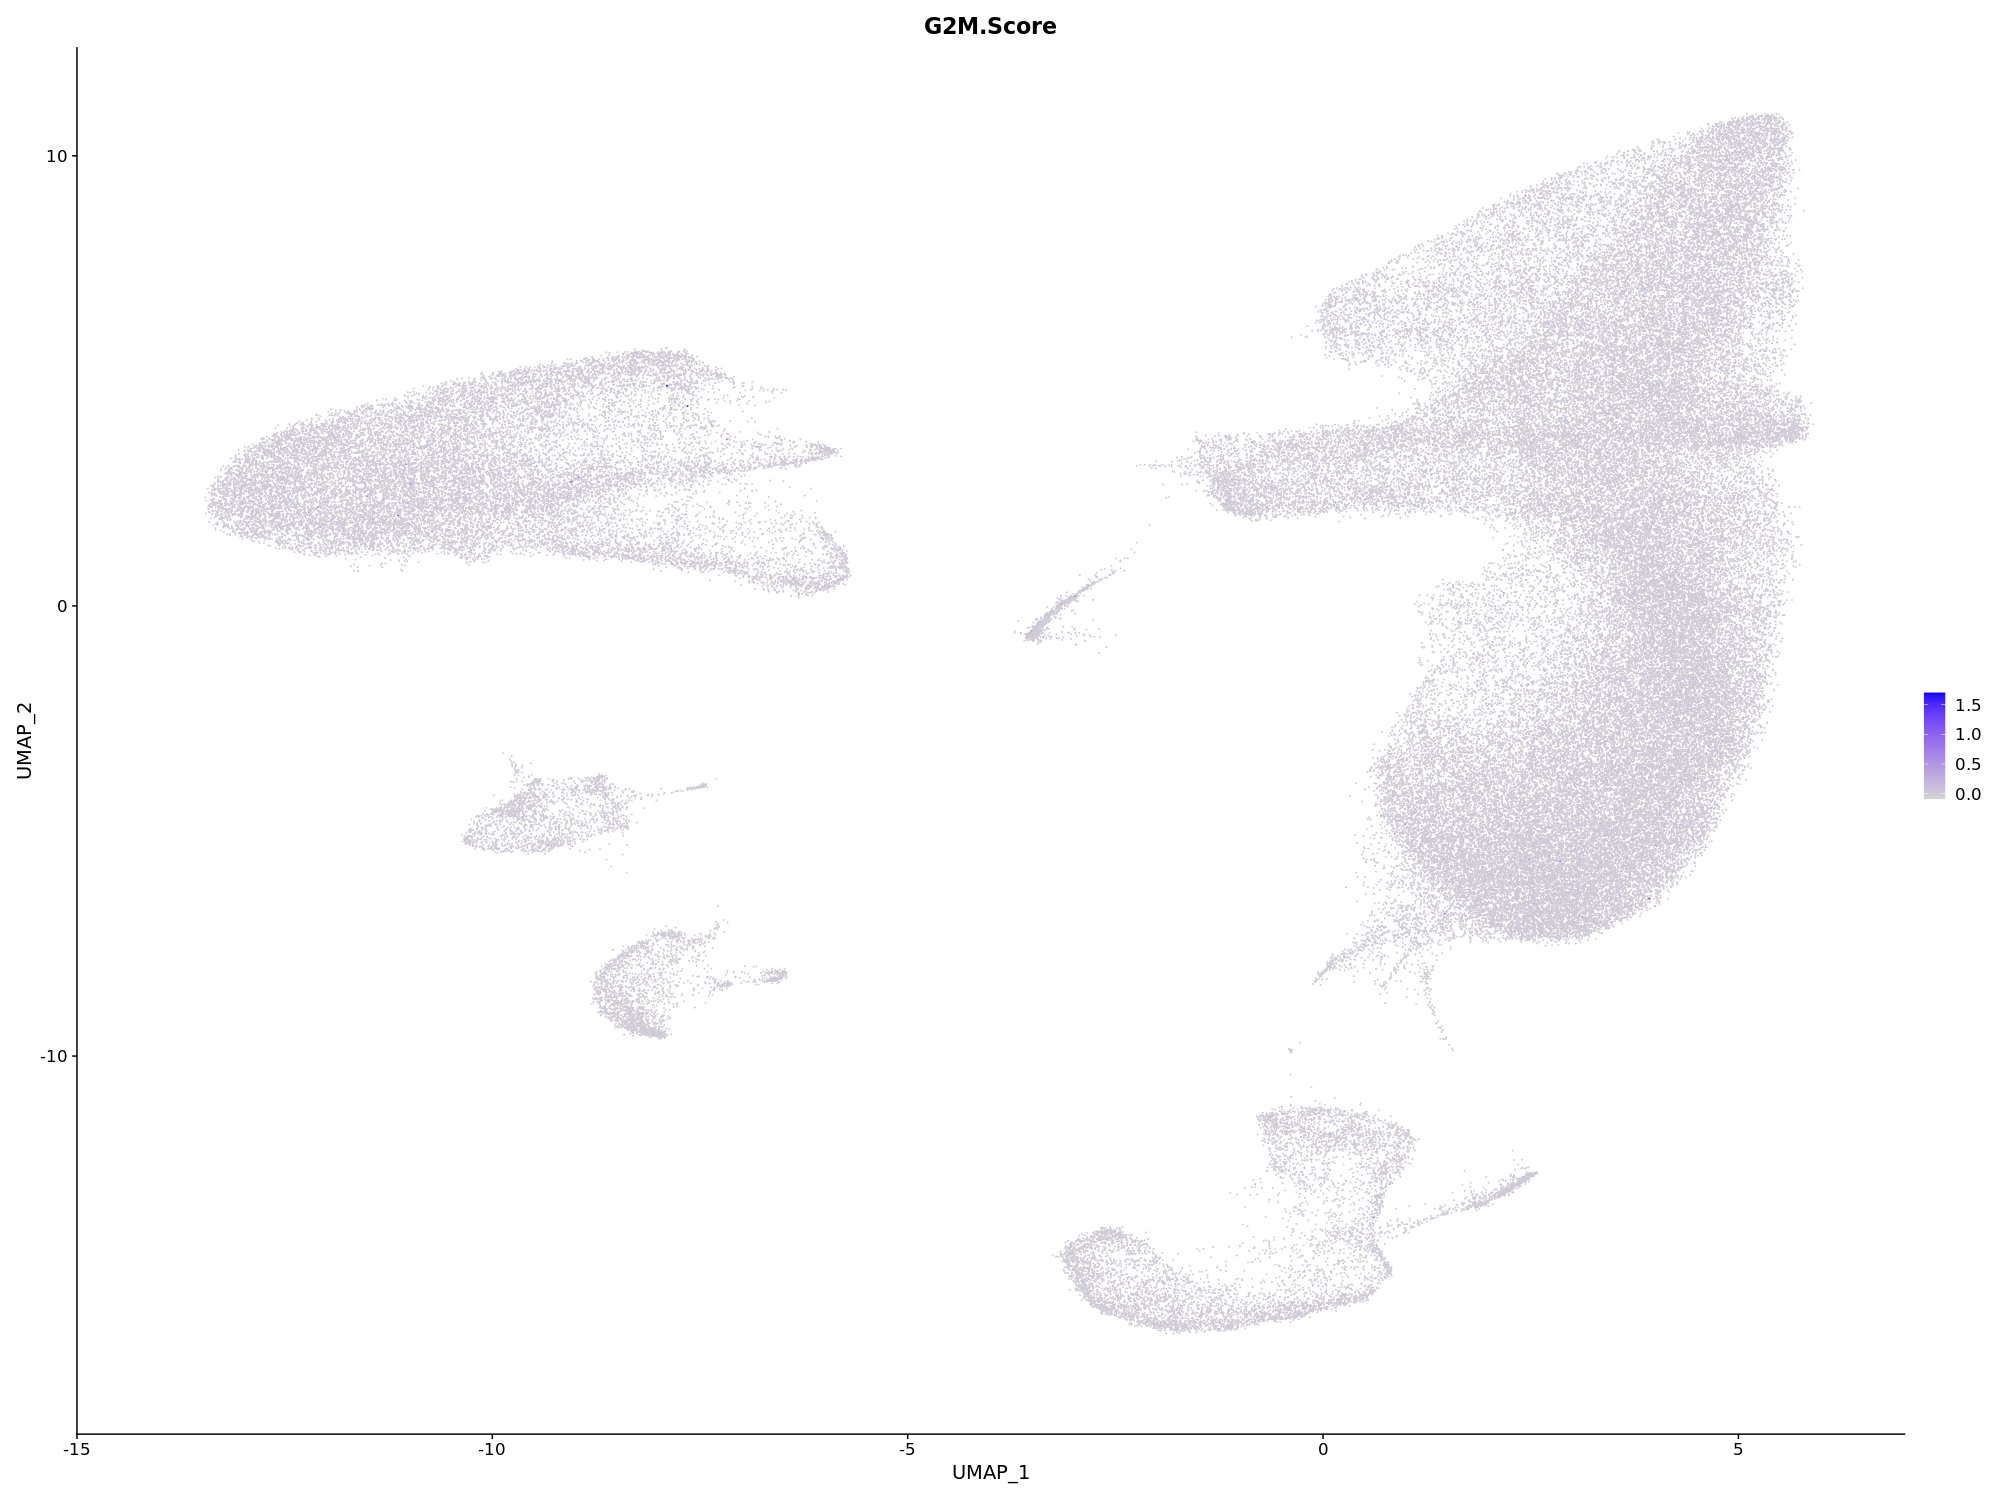

In [20]:
FeaturePlot(srt, features="G2M.Score", raster=F)

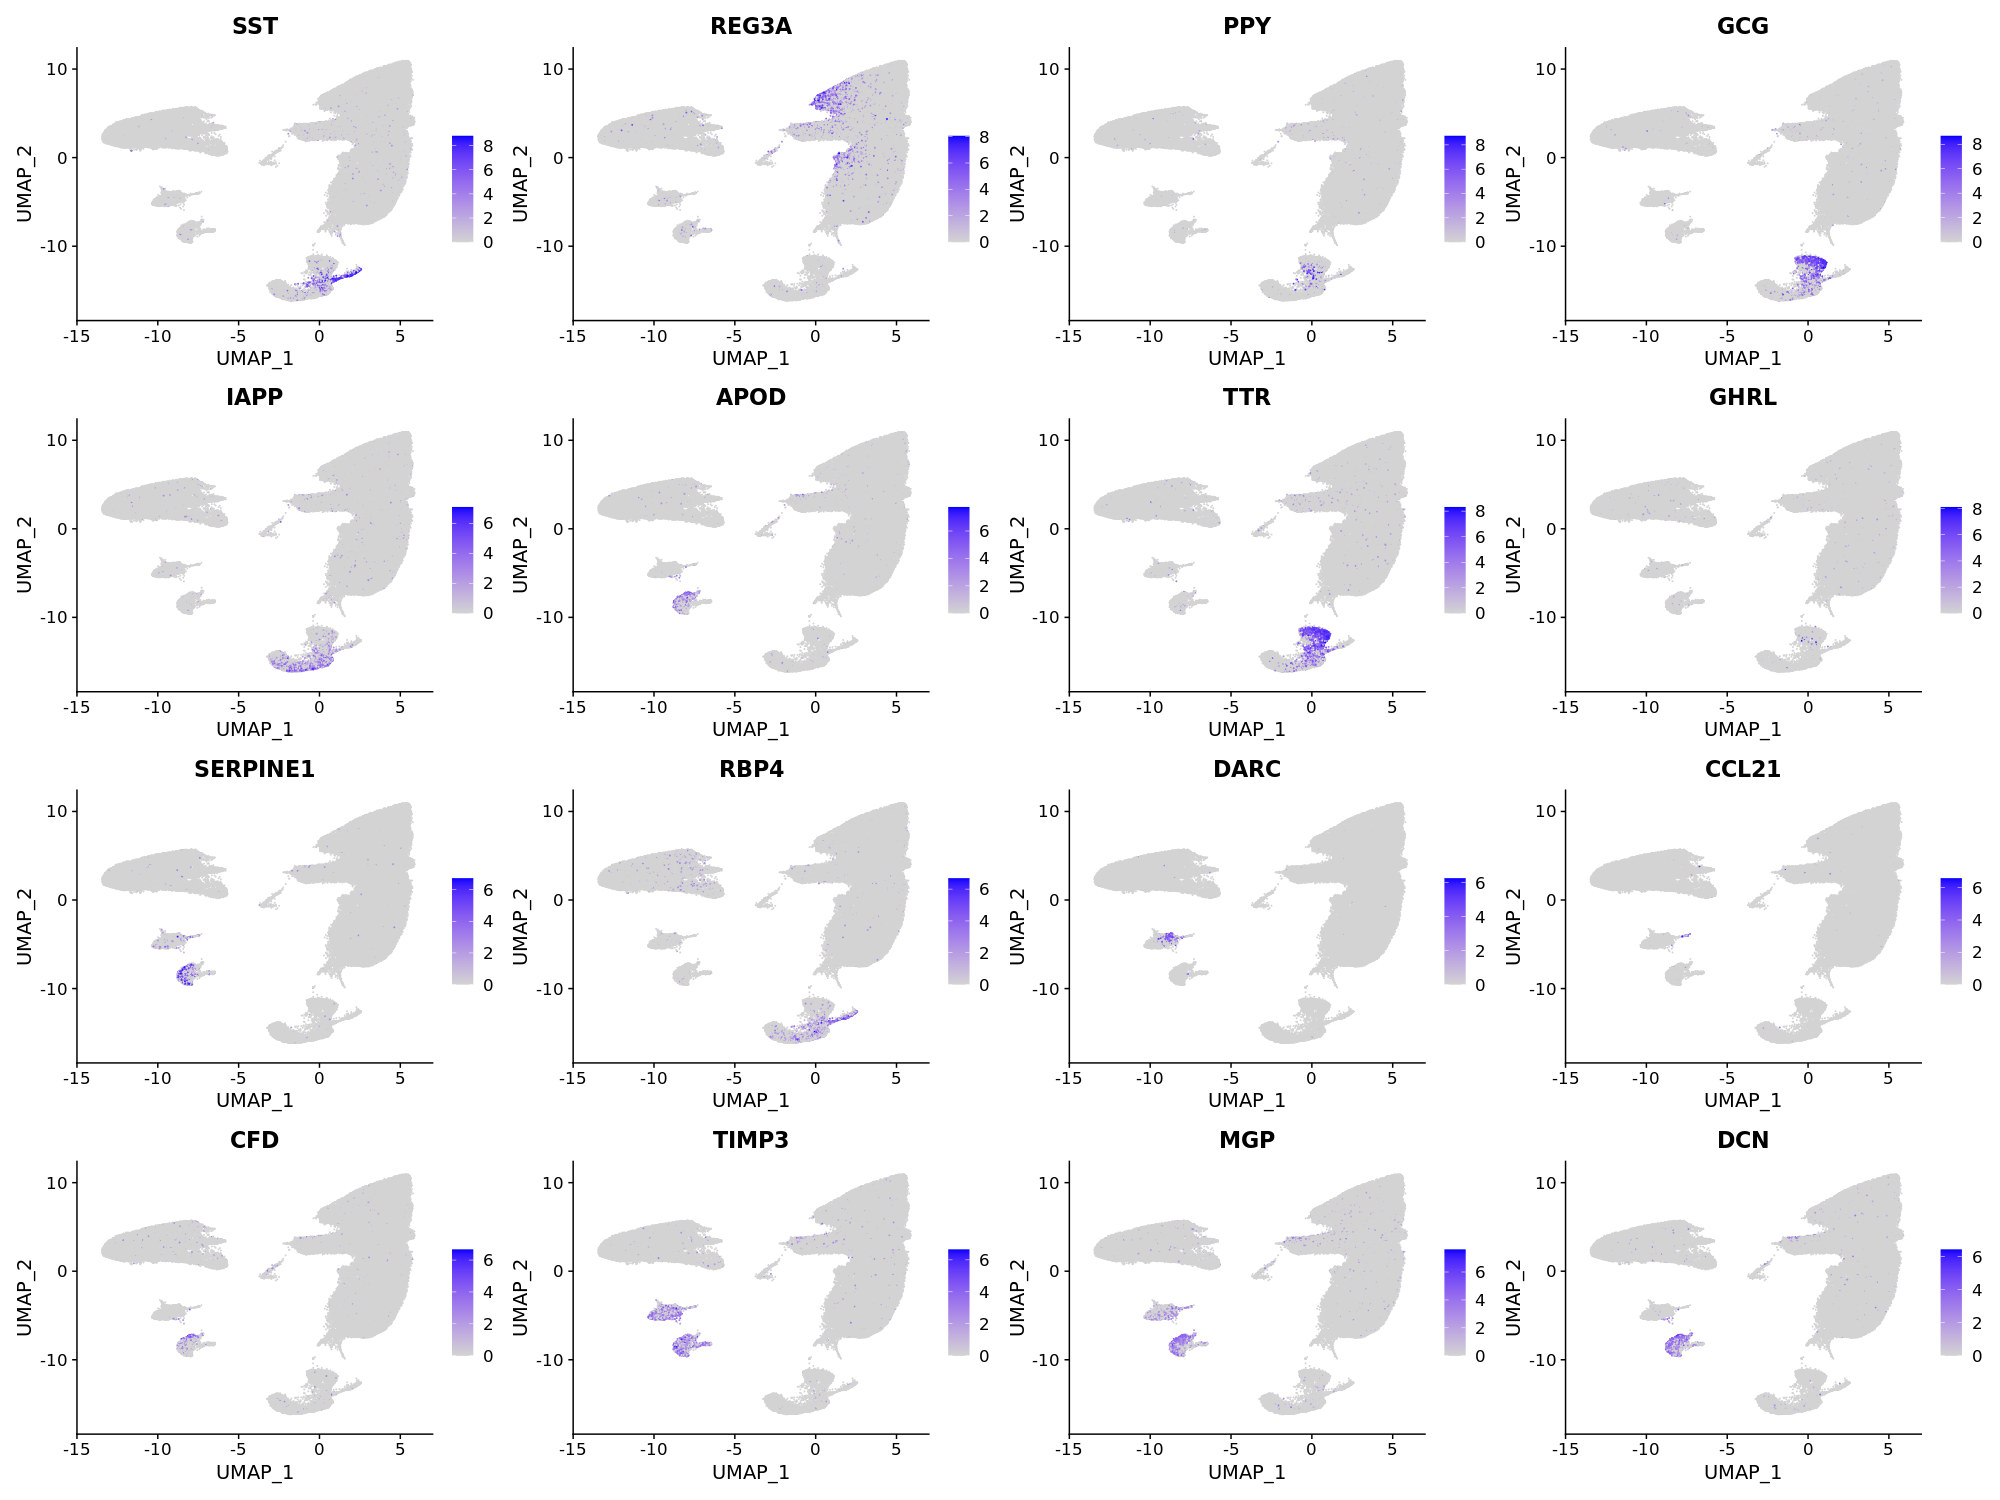

In [17]:
# FeaturePlot(srt, features=head(VariableFeatures(a), 16), raster=F)

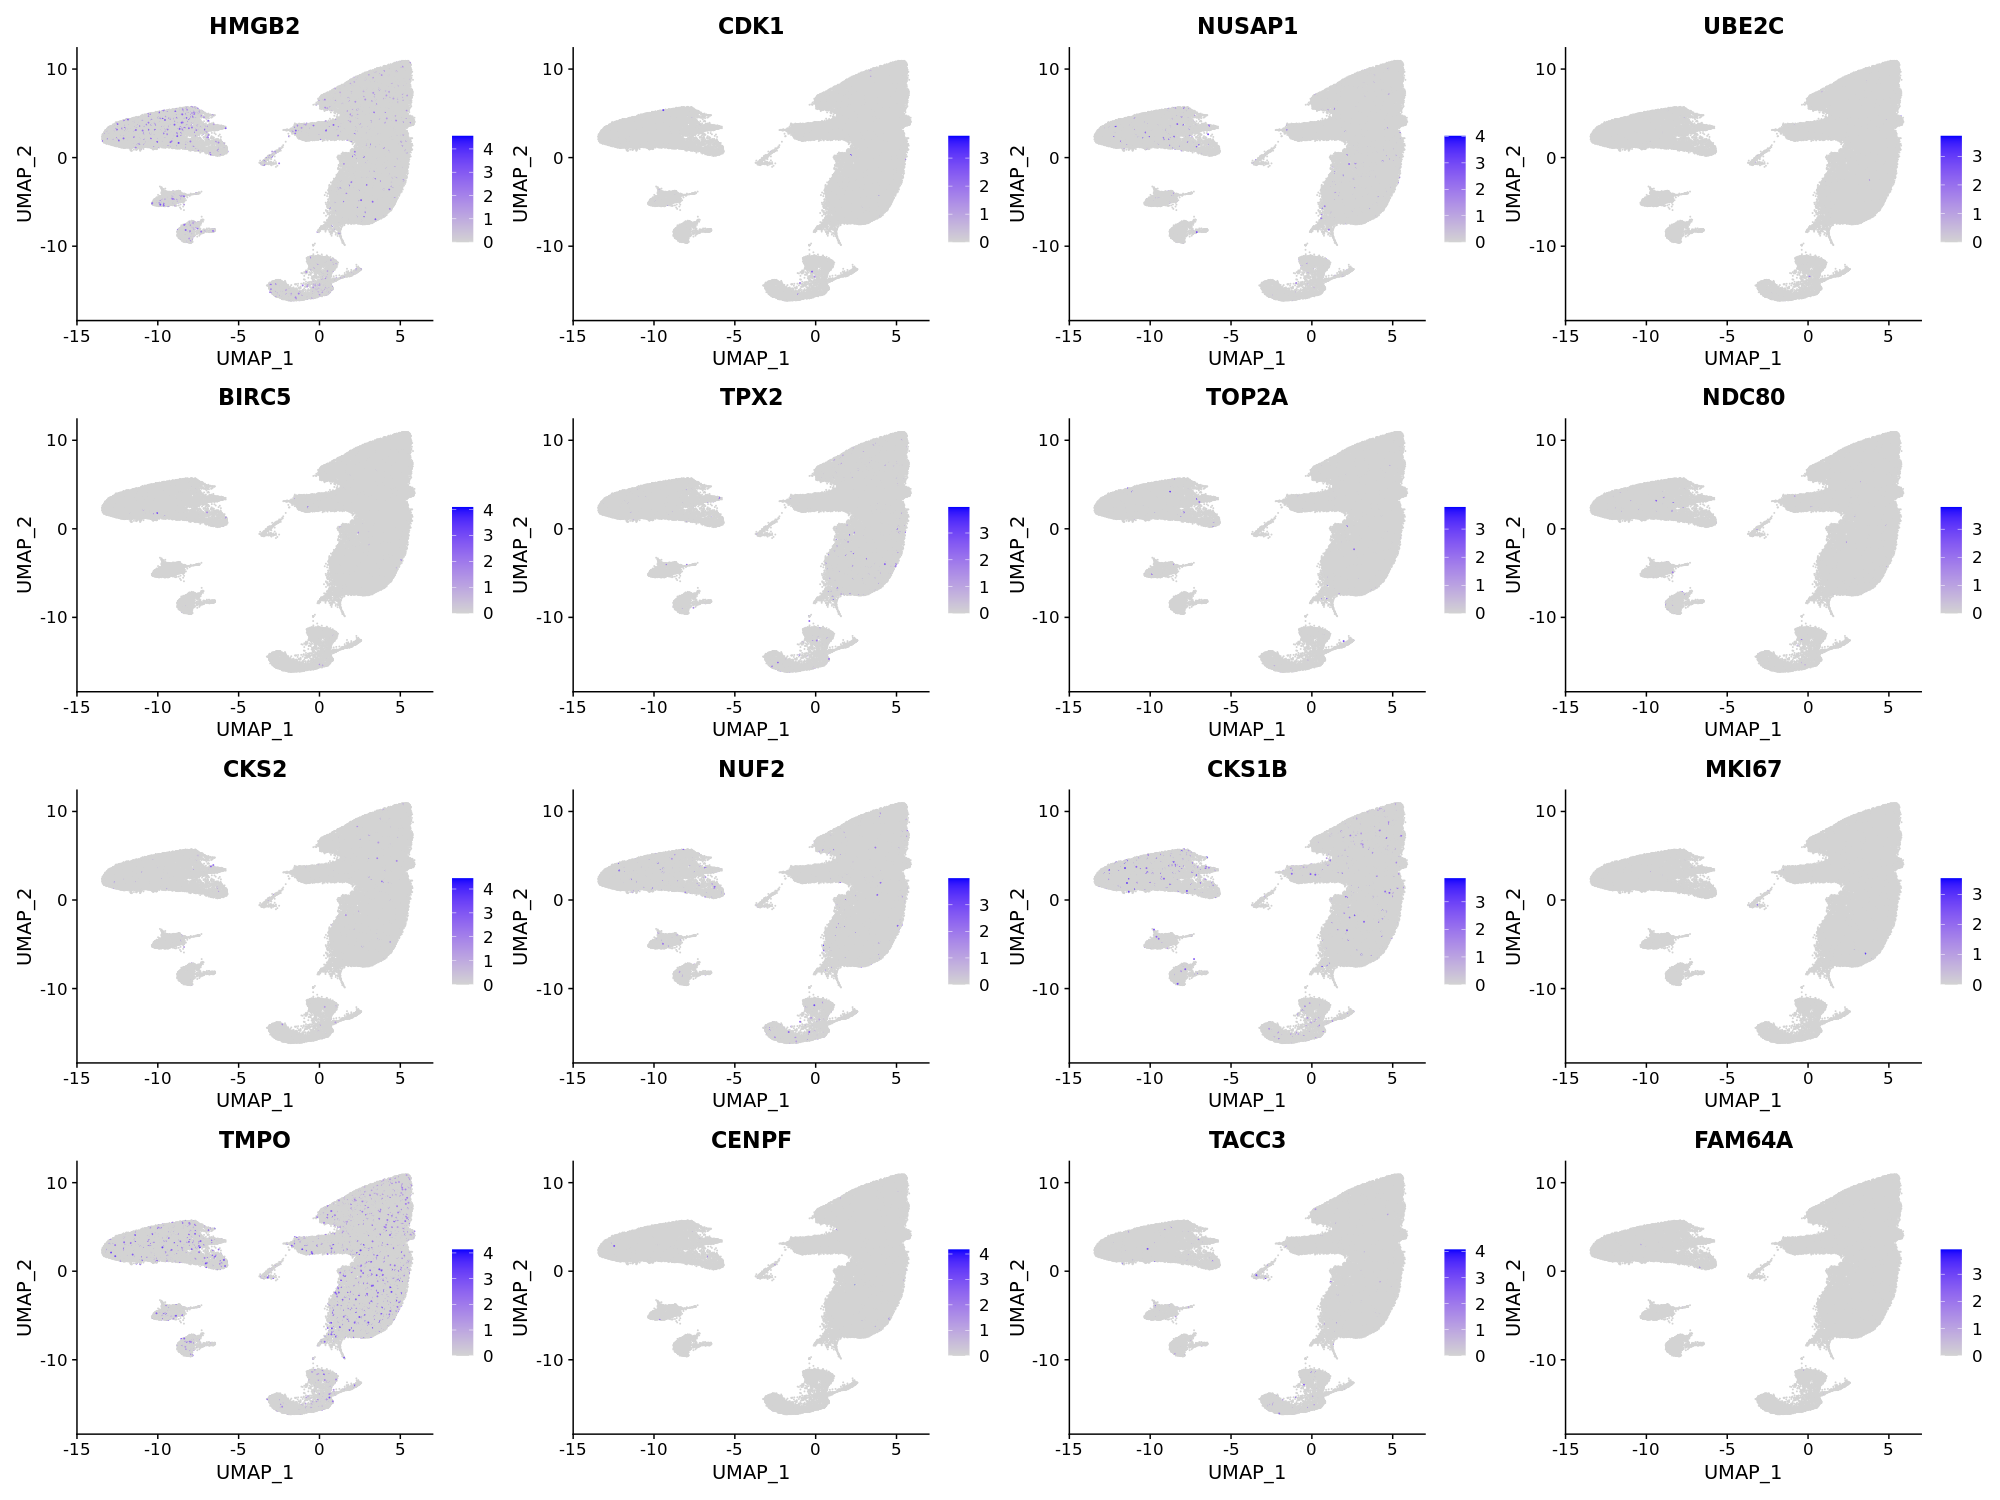

In [16]:
FeaturePlot(srt, features=c(g2m.genes[1:16]),raster=F)

In [11]:
g2m.genes

[1] "HMGB2"   "CDK1"    "NUSAP1"  "UBE2C"   "BIRC5"   "TPX2"    "TOP2A"  
 [8] "NDC80"   "CKS2"    "NUF2"    "CKS1B"   "MKI67"   "TMPO"    "CENPF"  
[15] "TACC3"   "FAM64A"  "SMC4"    "CCNB2"   "CKAP2L"  "CKAP2"   "AURKB"  
[22] "BUB1"    "KIF11"   "ANP32E"  "TUBB4B"  "GTSE1"   "KIF20B"  "HJURP"  
[29] "CDCA3"   "HN1"     "CDC20"   "TTK"     "CDC25C"  "KIF2C"   "RANGAP1"
[36] "NCAPD2"  "DLGAP5"  "CDCA2"   "CDCA8"   "ECT2"    "KIF23"   "HMMR"   
[43] "AURKA"   "PSRC1"   "ANLN"    "LBR"     "CKAP5"   "CENPE"   "CTCF"   
[50] "NEK2"    "G2E3"    "GAS2L3"  "CBX5"    "CENPA"

In [26]:
p = FeaturePlot(srt, features=g2m.genes[1:20])

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To di

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To di

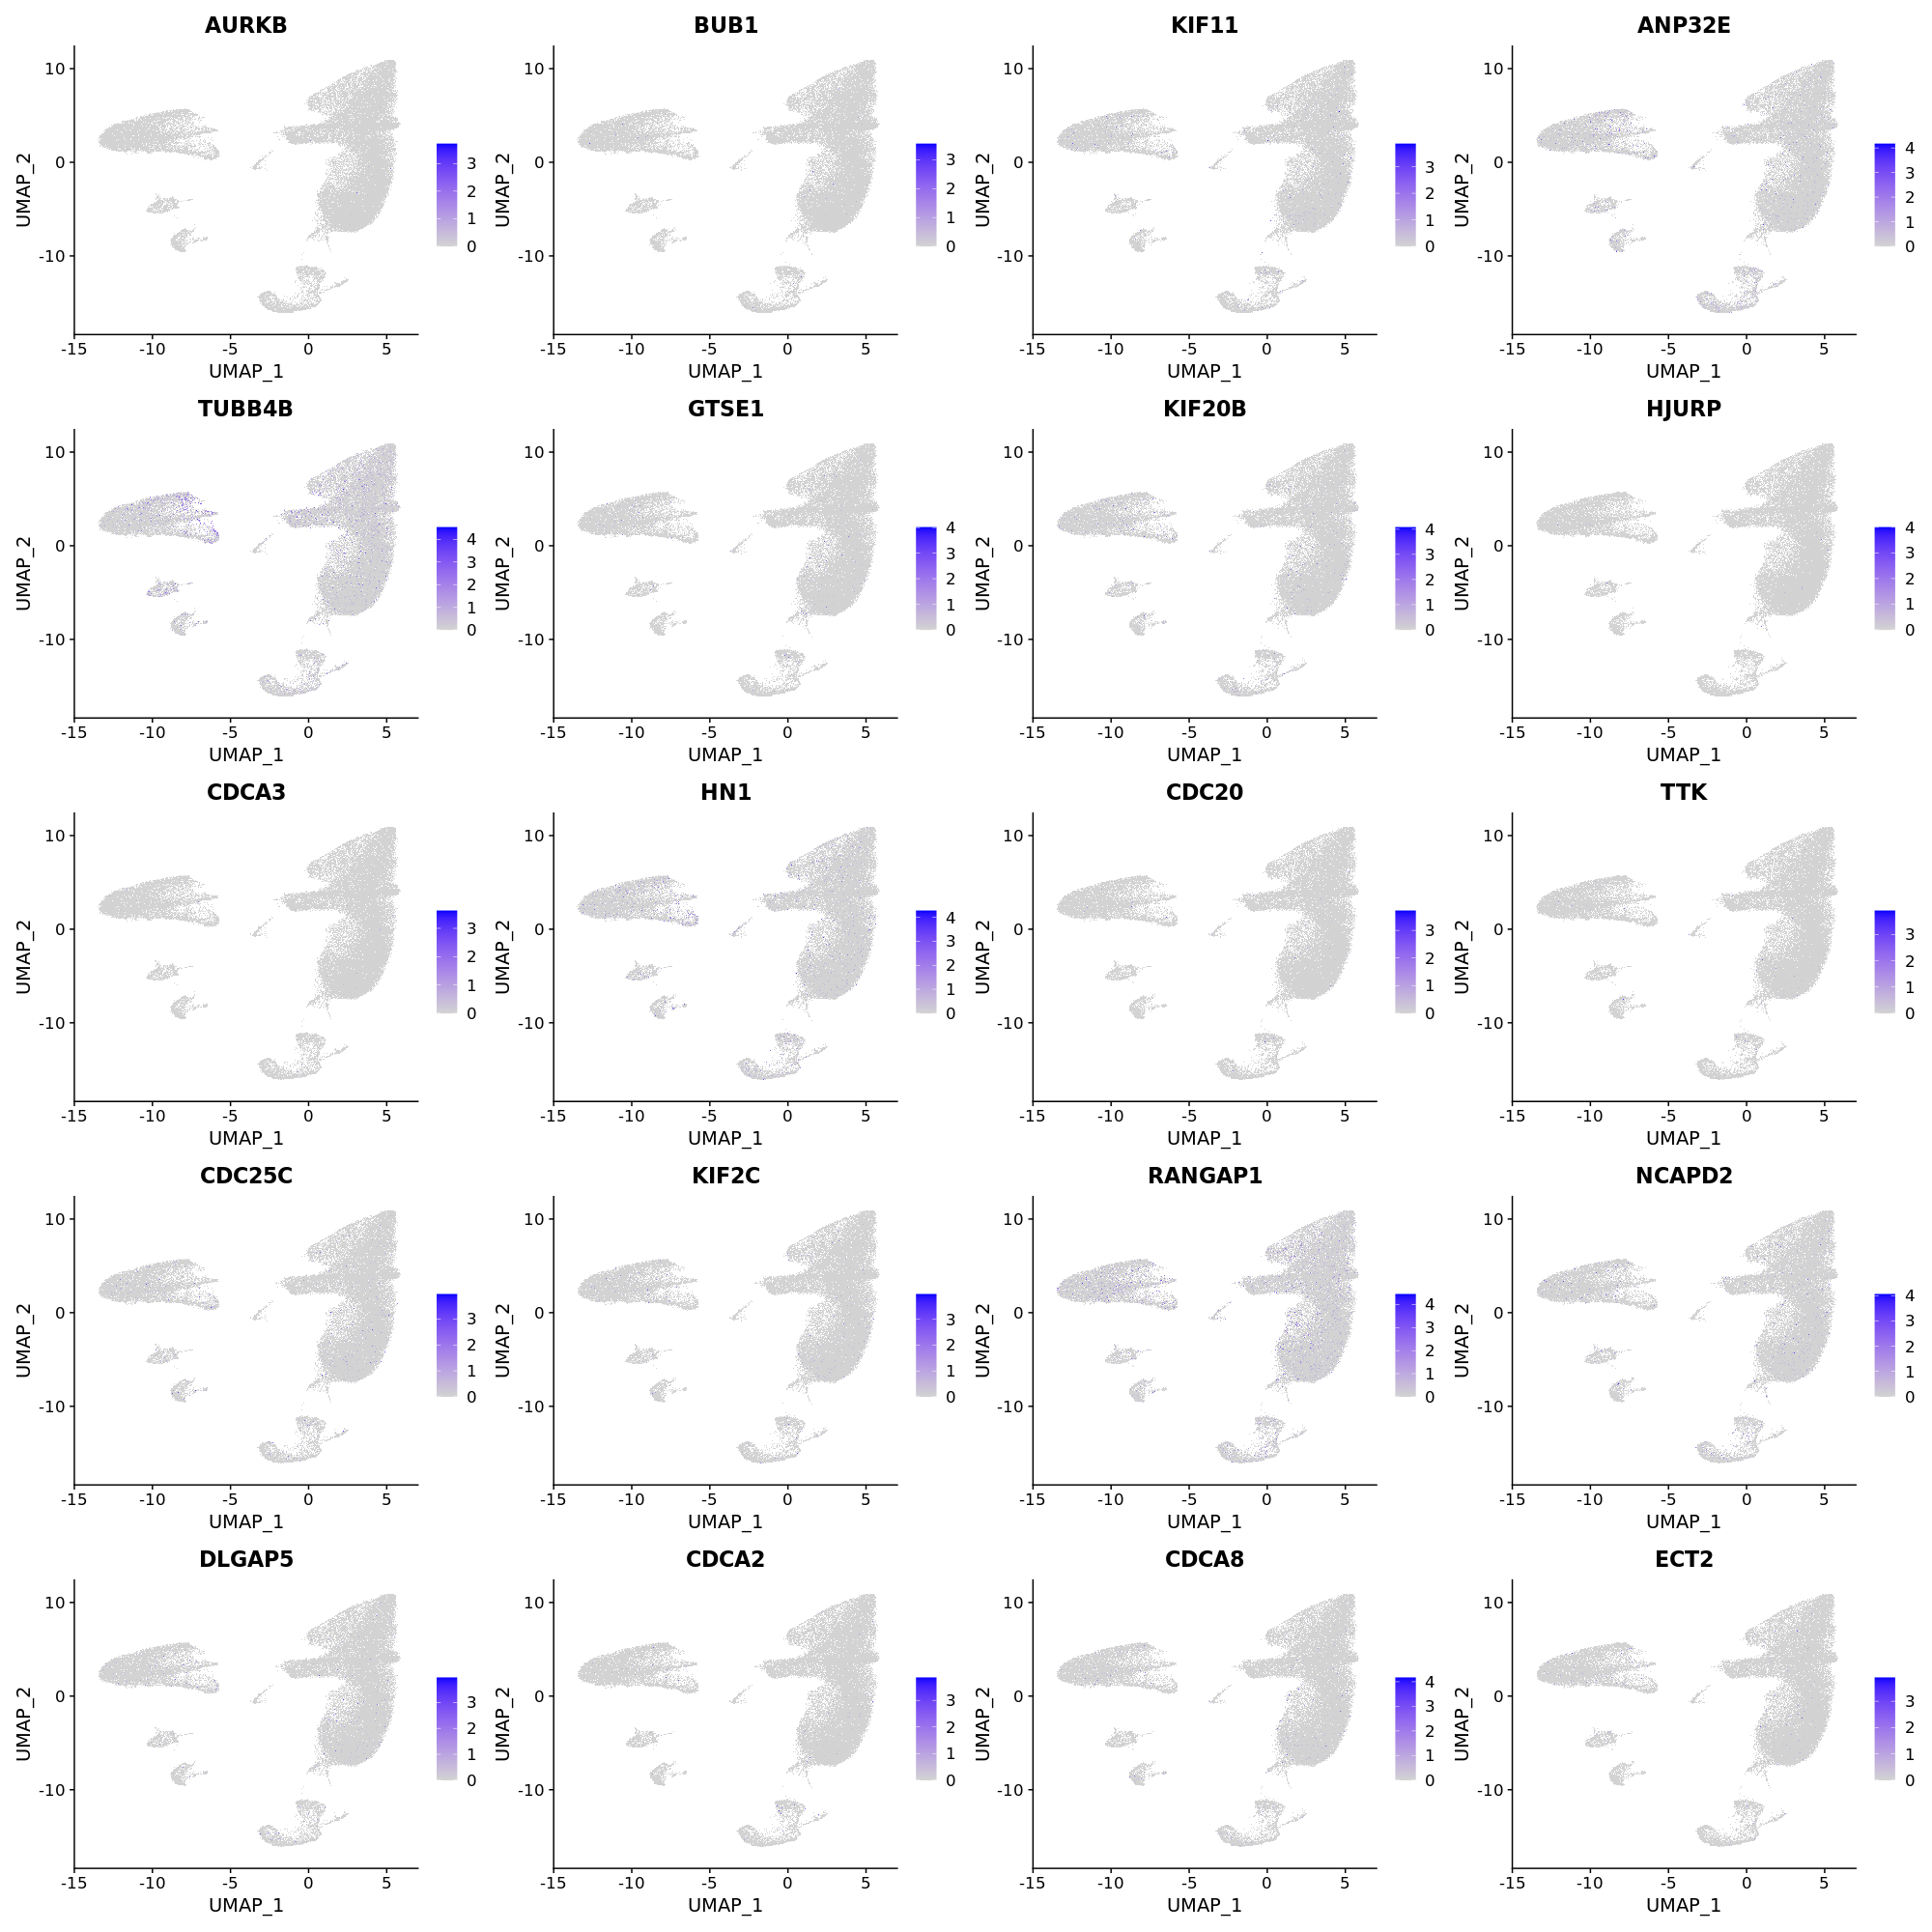

In [25]:
FeaturePlot(srt, features=g2m.genes[21:40])